# Our Implementation for K3 Coloring
The goal of this notebook is to implement and test our [Grover search based list coloring algorithm](https://arxiv.org/abs/2108.09061) on the Amazon Statevector Simulator and the IonQ Quantum Device, and compare our performance with the simulator output of the previous work of [Saha et. al.](https://arxiv.org/pdf/2009.06073.pdf).

In [1]:
# Install blueqat
# !pip install blueqat blueqat-cloud

# Import Libraries
from blueqat import circuit
import math
import numpy as np
import matplotlib.pyplot as plt

# Create the triangle graph
vertices = [0, 1, 2]
edges = [[0,1], [1,2], [0,2]]

In [2]:
# Toffoli and CCCX Gate Implementation
def apply_ccx(circuit, control0, control1, target):
    # circuit.ccx[control0, control1, target]
    circuit.h[target].cx[control1, target].rz(-0.7853981633974483)[target]
    circuit.cx[control0, target].rz(0.7853981633974483)[target].cx[control1, target]
    circuit.rz(-0.7853981633974483)[target].cx[control0, target].rz(0.7853981633974483)[target].h[target]
    circuit.rz(-0.7853981633974483)[control1].cx[control0, control1]
    circuit.rz(-0.7853981633974483)[control1].cx[control0, control1].rz(0.7853981633974483)[control0]
    circuit.rz(1.5707963267948966)[control1]
    
def apply_cccx(circuit, controls, target, ancilla):
    # Applies a CCCX gate onto the circuit. Requires a clean ancilla qubit.
    assert len(controls) == 3, '3 controls were not provided: CCCX gate needs a list of controls of size 3.'
    apply_ccx(circuit, controls[0], controls[1], ancilla)
    apply_ccx(circuit, controls[2], ancilla, target)
    apply_ccx(circuit, controls[0], controls[1], ancilla)

In [3]:
# Initialization Operators

def apply_E3(circuit, targets):
    # Applies an E3 gate on two qubits.
    assert len(targets) == 2, 'E3 only acts on 2 qubits.'
    # circuit.ry(2*np.arcsin(np.sqrt(2/3)))[targets[0]]
    # circuit.ch[targets[0],targets[1]]
    circuit.ry(1.9106332362490186)[targets[0]].rz(1.5707963267948966)[targets[1]].h[targets[1]].rz(0.7853981633974483)[targets[1]].cx[targets[0], targets[1]].rz(-0.7853981633974483)[targets[1]].h[targets[1]].rz(-1.5707963267948966)[targets[1]].x[targets[0]]
    # circuit.s[targets[1]].h[targets[1]].t[targets[1]].cnot[targets[0],targets[1]].tdg[targets[1]].h[targets[1]].sdg[targets[1]]
    # circuit.x[targets[1]]

def apply_E3_dagger(circuit, targets):
    # Applies an E3_dagger on two qubits.
    assert len(targets) == 2, 'E3 only acts on 2 qubits.'
    circuit.x[targets[0]].rz(1.5707963267948966)[targets[1]].h[targets[1]].rz(0.7853981633974483)[targets[1]].cx[targets[0], targets[1]].rz(-0.7853981633974483)[targets[1]].h[targets[1]].rz(-1.5707963267948966)[targets[1]].ry(-1.9106332362490186)[targets[0]]
    # circuit.x[targets[1]]
    # circuit.ch[targets[0],targets[1]]
    # circuit.sdg[targets[1]].h[targets[1]].tdg[targets[1]].cnot[targets[0],targets[1]].t[targets[1]].h[targets[1]].s[targets[1]]
    # circuit.ry(-2*np.arcsin(np.sqrt(2/3)))[targets[0]]

In [4]:
# Diffusion Operator

def apply_diffusion(circuit, vertex_qubits, clean_ancilla):
    assert len(vertex_qubits) == 6, 'Only implemented for 3 vertices and 6 qubits!'
    for i in range(int(len(vertex_qubits)/2)):
        apply_E3_dagger(circuit, [vertex_qubits[2*i], vertex_qubits[2*i+1]])
    
    # Put in anticontrolled toffoli
    circuit.x[vertex_qubits[0]].x[vertex_qubits[1]].x[vertex_qubits[2]]
    circuit.x[vertex_qubits[-1]].h[vertex_qubits[-1]]
    apply_cccx(circuit, vertex_qubits[0:3], vertex_qubits[-1], clean_ancilla)
    circuit.h[vertex_qubits[-1]].x[vertex_qubits[-1]]
    circuit.x[vertex_qubits[0]].x[vertex_qubits[1]].x[vertex_qubits[2]]
    
    for i in range(int(len(vertex_qubits)/2)):
        apply_E3(circuit, [vertex_qubits[2*i], vertex_qubits[2*i+1]])

In [5]:
# Oracle Part 1: Color Check

def apply_color_check(circuit, edges, vertex_qubits, edge_qubits):
    # for each edge, apply two toffoli gates onto its corresponding qubit
    for i in range(len(edges)):
        # get the vertices u,v incident to the i'th edge
        e = edges[i]
        u = e[0]
        v = e[1]
        # apply two anticontrol toffolis
        circuit.x[vertex_qubits[2*u]]
        circuit.x[vertex_qubits[2*v+1]]
        apply_ccx(circuit, vertex_qubits[2*u], vertex_qubits[2*v+1], edge_qubits[i])
        circuit.x[vertex_qubits[2*u]]
        circuit.x[vertex_qubits[2*v+1]]
        circuit.x[vertex_qubits[2*u+1]]
        circuit.x[vertex_qubits[2*v]]
        apply_ccx(circuit, vertex_qubits[2*u+1], vertex_qubits[2*v], edge_qubits[i])
        circuit.x[vertex_qubits[2*u+1]]
        circuit.x[vertex_qubits[2*v]]

In [6]:
# Full Oracle

def apply_grover_oracle(circuit, edges, vertex_qubits, edge_qubits, phase_flip_ancilla, clean_ancilla):
    apply_color_check(circuit, edges, vertex_qubits, edge_qubits)
    apply_cccx(circuit, controls=edge_qubits, target=phase_flip_ancilla, ancilla=clean_ancilla)
    apply_color_check(circuit, edges, vertex_qubits, edge_qubits)

In [7]:
# Setting the circuit and registers
from blueqat import Circuit
qc = Circuit(11)
vertex_qubits = list(range(6))
edge_qubits = list(range(6,9))
phase_flip_ancilla = 9
clean_ancilla = 10

# Circuit Initialization
for v in vertices:
    apply_E3(qc, [vertex_qubits[2*v], vertex_qubits[2*v+1]])
qc.h[phase_flip_ancilla].z[phase_flip_ancilla]

num_iter = 1 # math.ceil(math.pi/4 * math.sqrt(2**6/6)) # We're cheating here since we know there are 6 solutions...
print('Using Grover Rotation {} times...'.format(num_iter))

for _ in range(num_iter):
    # Oracle
    apply_grover_oracle(qc, edges, vertex_qubits, edge_qubits, phase_flip_ancilla, clean_ancilla)

    # Diffusion
    apply_diffusion(qc, vertex_qubits, clean_ancilla)

# Get the most frequent result on blueqat simulator
'''
num_shots = 2000
r_dict = qc.m[0:6].run(shots=num_shots) # .most_common(5)
print(r_dict)
r = r_dict.most_common(5)
r = r[0][0]
print('Vertex 0: {}\nVertex 1: {}\nVertex 2: {}'.format(int(r[0:2],2),int(r[2:4],2), int(r[4:6],2)))
'''

# Compute the number of elementary operations
print('Number of operations: ' + str(qc.to_qasm().count(';')-4))

Using Grover Rotation 1 times...
Number of operations: 429


## Testing on Amazon Statevector Simulator

In [8]:
import bqcloud
api = bqcloud.load_api()
# api = bqcloud.register_api("api_key")

In [9]:
num_shots = 2000
task1 = api.execute(qc, bqcloud.Device.SimSv1, num_shots)

In [10]:
print(task1.status())

Status.COMPLETED


In [11]:
# Fetch Measurement Results
result = task1.wait()

# Compute Measurement Results from first 6 qubits
c = result.shots().items()
# c = r_dict.items()
dict = {}
for k,v in c:
    if k[:6] in dict.keys():
        dict[k[:6]] = dict[k[:6]] + v
    else:
        dict[k[:6]] = v

print(dict)

# Export result to CSV
with open('Ours_3coloring_shot_counts_SimSv1_' + str(num_shots) + '.csv', encoding='utf-8-sig', mode='w') as fp:
    fp.write('State;Probability\n')  
    for state, count in dict.items():  
        fp.write('\'{}\';{}\n'.format(state, count/num_shots))

{'100001': 363, '100100': 347, '011000': 329, '101000': 2, '010010': 320, '000110': 301, '001001': 319, '010110': 2, '100010': 2, '011010': 2, '010001': 1, '001000': 4, '011001': 1, '000010': 2, '000101': 1, '000001': 1, '010100': 1, '101010': 2}


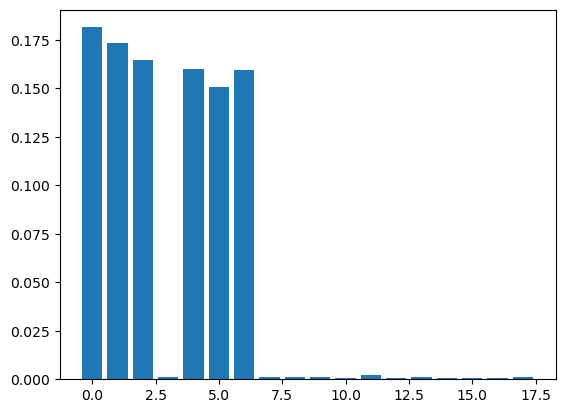

In [12]:
x = dict.keys()
y = [i/num_shots for i in dict.values()]
plt.bar(range(len(x)), y)
plt.show()

## Testing on the IonQ Device

In [13]:
task2 = api.execute(qc, bqcloud.Device.IonQDevice, num_shots)

In [16]:
task2.update()
print(task2.status())

Status.COMPLETED


In [17]:
result = task2.wait(timeout=10)
if result:
    print(result.shots())
else:
    print("timeout")

Counter({'01000001011': 6, '10100001011': 6, '10101000010': 5, '00101100010': 5, '10101100010': 5, '10001000110': 5, '00000011110': 5, '11010000100': 4, '01101111100': 4, '01110000010': 4, '01001000010': 4, '00111110010': 4, '01100001010': 4, '11100101010': 4, '01101101010': 4, '11000001110': 4, '10111001110': 4, '01011101110': 4, '00001000001': 4, '00011000001': 4, '00101110001': 4, '10000101001': 4, '10111011001': 4, '00110010101': 4, '10010010011': 4, '00101010011': 4, '10111110011': 4, '11111011011': 4, '00001111011': 4, '01101000111': 4, '01010100111': 4, '01001110111': 4, '10101110111': 4, '11111001111': 4, '00011101111': 4, '01100000000': 3, '01100100000': 3, '10011010000': 3, '01011110000': 3, '10000001000': 3, '01001101000': 3, '01101011000': 3, '10001111000': 3, '11100100100': 3, '00101100100': 3, '00111100100': 3, '10100010100': 3, '00001010100': 3, '10111010100': 3, '11100110100': 3, '10000001100': 3, '11110101100': 3, '00001101100': 3, '10000011100': 3, '00101011100': 3, '

In [18]:
c = result.shots().items()
# c = r_dict.items()
dict = {}
for k,v in c:
    if k[:6] in dict.keys():
        dict[k[:6]] = dict[k[:6]] + v
    else:
        dict[k[:6]] = v
print(dict)

# Export results to local csv file
with open('Ours_3coloring_shot_counts_IonQ'+str(num_shots)+'.csv', encoding='utf-8-sig', mode='w') as fp:
    fp.write('State;Probability\n')  
    for state, count in dict.items():  
        fp.write('\'{}\';{}\n'.format(state, count/num_shots))  

{'000000': 34, '101000': 40, '011000': 39, '111000': 34, '000100': 30, '001100': 36, '011100': 24, '000010': 37, '100010': 37, '110010': 19, '001010': 39, '101010': 39, '011010': 36, '111010': 30, '000110': 33, '010110': 23, '110110': 34, '001110': 24, '101110': 41, '011110': 31, '111110': 33, '000001': 18, '110001': 28, '011001': 32, '000101': 21, '010101': 38, '101101': 34, '011101': 29, '111101': 28, '100011': 33, '001011': 45, '011011': 34, '111011': 33, '000111': 31, '100111': 20, '110111': 23, '001111': 28, '101111': 33, '011111': 23, '111111': 37, '100000': 41, '010000': 33, '110000': 35, '100100': 28, '110100': 34, '100110': 22, '100001': 31, '010001': 33, '001001': 34, '111001': 33, '110011': 29, '101011': 40, '010111': 18, '010100': 29, '101100': 24, '111100': 31, '010010': 32, '101001': 43, '001101': 25, '000011': 36, '010011': 31, '001000': 27, '100101': 28, '110101': 22}


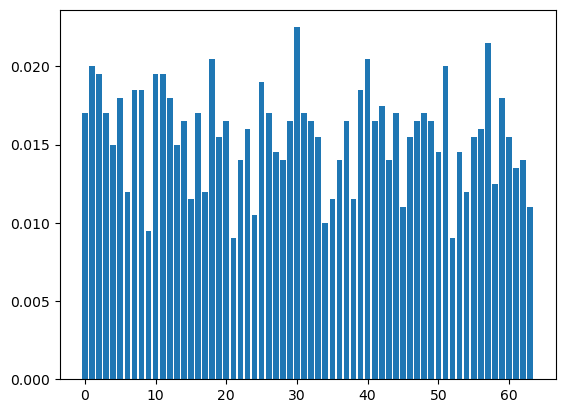

In [19]:
x = dict.keys()
y = [i/num_shots for i in dict.values()]
plt.bar(range(len(x)), y)
plt.show()

# Saha et. al. Implementation for K3 coloring

We now implement the circuit in Figure 8, Page 5 of [Saha et. al.](https://arxiv.org/pdf/2009.06073.pdf).

In [20]:
def apply_ccccx(circuit, control0, control1, control2, control3, target, ancilla0, ancilla1):
    apply_ccx(circuit, control0, control1, ancilla0)
    apply_ccx(circuit, control2, control3, ancilla1)
    apply_ccx(circuit, ancilla0, ancilla1, target)
    apply_ccx(circuit, control2, control3, ancilla1)
    apply_ccx(circuit, control0, control1, ancilla0)

In [22]:
saha_circ = Circuit(13)
vqubit = list(range(6))
equbit = list(range(6,9))
ranc = 9
pflip = 10
anc0 = 11
anc1 = 12

for i in vqubit:
    saha_circ.h[i]
for i in equbit:
    saha_circ.x[i]
saha_circ.x[pflip].h[pflip]

# ORACLE
# block1
apply_ccx(saha_circ,0,1,6)
apply_ccx(saha_circ,2,3,7)
apply_ccx(saha_circ,4,5,8)
apply_cccx(saha_circ,[6,7,8],9,anc0)
apply_ccx(saha_circ,4,5,8)
apply_ccx(saha_circ,2,3,7)
apply_ccx(saha_circ,0,1,6)

#block2
saha_circ.cx[0,2]
saha_circ.cx[1,3]
saha_circ.x[2]
saha_circ.x[3]
apply_ccx(saha_circ,2,3,6)
saha_circ.cx[0,4]
saha_circ.cx[1,5]
saha_circ.x[4]
saha_circ.x[5]
apply_ccx(saha_circ,4,5,7)
apply_ccx(saha_circ,6,7,8)
apply_ccx(saha_circ,4,5,7)
saha_circ.x[5]
saha_circ.x[4]
saha_circ.cx[1,5]
saha_circ.cx[0,4]
apply_ccx(saha_circ,2,3,6)
saha_circ.x[3]
saha_circ.x[2]
saha_circ.cx[1,3]
saha_circ.cx[0,2]

# block3
saha_circ.cx[2,4]
saha_circ.cx[3,5]
saha_circ.x[4]
saha_circ.x[5]
apply_ccx(saha_circ,4,5,6)
apply_ccccx(saha_circ,6,7,8,9,10,anc0,anc1)
apply_ccx(saha_circ, 4,5,6)
saha_circ.x[5]
saha_circ.x[4]
saha_circ.cx[3,5]
saha_circ.cx[2,4]

# block4
saha_circ.cx[0,2]
saha_circ.cx[1,3]
saha_circ.x[2]
saha_circ.x[3]
apply_ccx(saha_circ,2,3,6)
saha_circ.cx[0,4]
saha_circ.cx[1,5]
saha_circ.x[4]
saha_circ.x[5]
apply_ccx(saha_circ,4,5,7)
apply_ccx(saha_circ,6,7,8)
apply_ccx(saha_circ,4,5,7)
saha_circ.x[5]
saha_circ.x[4]
saha_circ.cx[1,5]
saha_circ.cx[0,4]
apply_ccx(saha_circ,2,3,6)
saha_circ.x[3]
saha_circ.x[2]
saha_circ.cx[1,3]
saha_circ.cx[0,2]

# block5
apply_ccx(saha_circ,0,1,6)
apply_ccx(saha_circ,2,3,7)
apply_ccx(saha_circ,4,5,8)
apply_cccx(saha_circ,[6,7,8],9,anc0)
apply_ccx(saha_circ,4,5,8)
apply_ccx(saha_circ,2,3,7)
apply_ccx(saha_circ,0,1,6)

# block6 (diff)

for i in vqubit:
    saha_circ.h[i].x[i]
saha_circ.h[vqubit[-1]]
apply_cccx(saha_circ,[0,1,2],vqubit[-1],anc0)
saha_circ.h[vqubit[-1]]
for i in vqubit:
    saha_circ.x[i].h[i]
saha_circ.h[pflip]

print('Number of operations: ' + str(saha_circ.to_qasm().count(';')-4))

Number of operations: 686


## Testing on Amazon Statevector Simulator

In [23]:
num_shots = 2000
task3 = api.execute(saha_circ, bqcloud.Device.SimSv1, num_shots)

In [24]:
print(task3.status())

Status.COMPLETED


In [25]:
# Fetch Measurement Results
result = task3.wait()

# Compute Measurement Results from first 6 qubits
c = result.shots().items()
# c = r_dict.items()
dict = {}
for k,v in c:
    if k[:6] in dict.keys():
        dict[k[:6]] = dict[k[:6]] + v
    else:
        dict[k[:6]] = v

# Export result to CSV
with open('Saha_et_al_3coloring_shot_counts_SimSv1_' + str(num_shots) + '.csv', encoding='utf-8-sig', mode='w') as fp:
    fp.write('State;Probability\n')  
    for state, count in dict.items():  
        fp.write('\'{}\';{}\n'.format(state, count/num_shots))

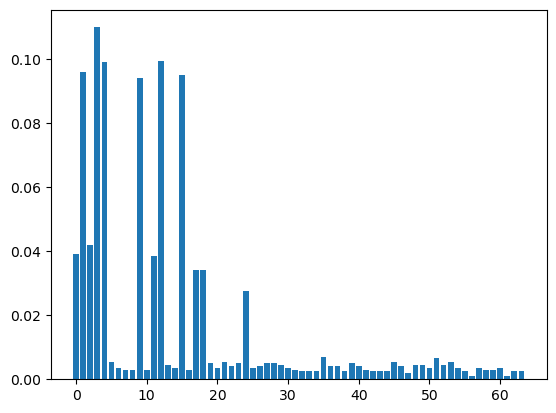

In [26]:
x = dict.keys()
y = [i/num_shots for i in dict.values()]
plt.bar(range(len(x)), y)
plt.show()

## IonQ Physical Device
Since we need 13 physical qubits to run this algorithm on the IonQ device, we could not run it.